#Comenzamos el proyecto ahora en un .ipynb, para que quede todo un poco más clarito. 


La estructura es:
-Descargamos unos datos de 3 fuentes distintas. Les damos formato, con dataclass. Se grafican para su analisis, se hace la matriz de varianzas y covariazas, se recomienda una cartera con pesos eficientes para esos valores. 

-En otra celda, intentaré descargar información relevante de la empresa y generar un archivo 

In [45]:

import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta, date
from dotenv import load_dotenv  # Para cargar nuestras claves API secretas
import json
import yfinance as yf
from twelvedata import TDClient
from dataclasses import dataclass, asdict 
import missingno as mso
import matplotlib.pyplot as plt
from numpy.random import default_rng
import cvxpy as cp
from scipy.linalg import sqrtm

print("✅ Librerías importadas con éxito.")

✅ Librerías importadas con éxito.


Creamos la @DataClass para estandarizar la estructura de los datos


In [46]:

@dataclass
class StockData: 
    symbol: str
    date: date # 'date' (solo fecha), no 'datetime' (fecha y hora), voy a trabajar con datos gratuitos EOD
    open: float 
    high: float 
    low: float
    close: float 
    volume: float 
    fuente_datos: str = "" # plataforma de los datos

print(f"Definido el 'molde' StockData: {StockData(symbol='EJEMPLO', date=date.today(), open=100.0, high=101.0, low=99.0, close=100.5, volume=1000, fuente_datos='Test')}")

Definido el 'molde' StockData: StockData(symbol='EJEMPLO', date=datetime.date(2025, 11, 5), open=100.0, high=101.0, low=99.0, close=100.5, volume=1000, fuente_datos='Test')


Cargamos las API de las fuentes, en este caso, 12data, Alpha vantage y finnhub

In [47]:
# # Define la ruta COMPLETA a tu archivo .env
# ruta_del_proyecto = "/Users/emiliosanchez/Desktop/MIAX/proyecto1_descarga_datos/proyecto1"
# ruta_env = os.path.join(ruta_del_proyecto, ".env")

# # Carga el .env desde esa ruta específica
# load_dotenv(dotenv_path=ruta_env)
# ALPHA_KEY = os.getenv("alpha_key")
# TWELVE_DATA_KEY = os.getenv("12data_key")

# if not ALPHA_KEY or not TWELVE_DATA_KEY:
#     # Si no encuentra las claves, detiene la ejecución con un error claro
#     raise SystemExit("❌ ERROR: No se encontraron las API keys en el .env. Revisar archivo.")
# else:
#     print("✅ API Keys cargadas correctamente.")

Definimos los parámetros de la descarga. Los valores, y el rango de fechas.


In [48]:
TICKERS = ['TSLA', 'ADBE', 'INTC', 'MSFT', 'NFLX', 'AMD', 'AAPL', 'NVDA', 'GOOGL', 'AMZN'] # ¡¡¡ aquí en un futuro cercano quiero que me lo pida por pantalla
end_date = datetime.today()
start_date = end_date - timedelta(days=10000) # lo msmo  ¡¡¡ aquí en un futuro cercano quiero que me lo pida por pantalla

# Convertimos las fechas a texto (string) en formato YYYY-MM-DD
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

print(f"Tickers a buscar: {TICKERS}")
print(f"Rango de fechas: {start_date_str} a {end_date_str}")

Tickers a buscar: ['TSLA', 'ADBE', 'INTC', 'MSFT', 'NFLX', 'AMD', 'AAPL', 'NVDA', 'GOOGL', 'AMZN']
Rango de fechas: 1998-06-20 a 2025-11-05


Ahora lo importante:
Definimos las 3 funciones de descarga de datos descarga de datos EOD

In [49]:
# --- 2.1 DE YAHOO FINANCE ---
def descargar_yfinance(symbol):
    """Descarga y limpia datos diarios de Yahoo Finance."""
    print(f"  -> Obteniendo datos de Yahoo Finance para {symbol}...")
    try:
        # auto_adjust=True ajusta los precios a splits/dividendos (obtiene Adj Close)
        df = yf.download(symbol, start=start_date_str, end=end_date_str, auto_adjust=True) 
       
        if df.empty:
            print(f"  ⚠️  {symbol} (Yahoo Finance): No se encontraron datos.")
            return None
        # Aplanar MultiIndex, si no da problemas al hacer el pd.concatisinstance() 
        # es una función que comprueba si las columnas de tu tabla de datos (df.columns) son de tipo MultiIndex.
        # Si la respuesta es sí, la siguiente línea se ejecuta eliminando la columna
        #lo de preguntar es una mera formalidad vaya, porque en Yahoo es que sí
   
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(1)

        
        # 1. Resetear el índice PRIMERO para que 'Date' se convierta en una columna
        df = df.reset_index()
        
        # 2. AHORA, convertir todos los nombres de columnas a minúsculas.
        df.columns = df.columns.str.lower()
        
        # El bloque 'adj close' se elimina, ya que auto_adjust=True pone el valor ajustado directamente en 'close'

        # Añadir columnas de metadatos
        df['symbol'] = symbol 
            
        print(f"  ✅ {symbol} (Yahoo Finance): {len(df)} filas descargadas (Adj Close).")
        print(df.head())
        return df
    except Exception as e:
        print(f"   ❌ {symbol} (Yahoo Finance): Ocurrió un error - {e}")
        return None

# # --- 2.2 DESCARGA DE ALPHA VANTAGE ---
# def descargar_alpha_vantage(symbol):
#     """Descarga datos diarios de Alpha Vantage."""
#     print(f"  -> Obteniendo datos de Alpha Vantage para {symbol}...")
#     try:
#         request= requests.get(f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=compact&apikey={ALPHA_KEY}", timeout=(5, 45))
#         request.raise_for_status() # Si hay un error (ej. 404, 500), se detiene aquí
#         data = request.json()
        
#         # El JSON de Alpha Vantage tiene una clave principal que cambia (ej. "Time Series (Daily)")
#         # Este bucle la encuentra 
#         key = None
#         for k in data:
#             if "Time Series" in k:
#                 key = k
#                 break 

#         if not key: 
#             print(f"  ⚠️  {symbol} (Alpha Vantage): No se encontró 'Time Series'. Respuesta: {data}")
#             return None 

#         df = pd.DataFrame.from_dict(data[key], orient='index', dtype=float) 
#         df.index = pd.to_datetime(df.index)
#         df = df[df.index >= start_date] # Filtramos por fecha
        
#         # Estandarizar nombres (Alpha usa "1. open", "2. high", etc.) 
#         df.columns = df.columns.str.replace(r'^\d+\.\s*', '', regex=True).str.lower() 
#         df = df[['open', 'high', 'low', 'close', 'volume']] # Nos aseguramos el orden 
        
#         df['symbol'] = symbol
#         df['date'] = df.index.to_pydatetime() # 'date' como columna 
#         df = df.reset_index(drop=True)
            
#         print(f"  ✅ {symbol} (Alpha Vantage): {len(df)} filas descargadas.")
#         print(df.head())
#         return df
#     except Exception as error:
#         print(f"  ❌ {symbol} (Alpha Vantage): Ocurrió un error - {error}")
#         return None

# # --- 2.3 DESCARGA DE TWELVE DATA ---
# def descargar_twelve_data(symbol):
#     """Descarga datos diarios de Twelve Data.""" 
#     print(f"  -> Obteniendo datos de Twelve Data para {symbol}...")
#     try:
#         td = TDClient(apikey=TWELVE_DATA_KEY)
#         ts = td.time_series(symbol=symbol, interval="1day", start_date=start_date_str, end_date=end_date_str, outputsize=5000)
        
#         if ts is None: 
#             print(f"  ⚠️  {symbol} (Twelve Data): No se encontraron datos.")
#             return None
        
#         # .as_pandas() lo convierte a DataFrame
#         # .iloc[::-1] invierte el orden (vienen del más nuevo al más viejo) 
#         df = ts.as_pandas().iloc[::-1].reset_index().rename(columns={'datetime': 'date'})
#         df['symbol'] = symbol
        
#         print(f"  ✅ {symbol} (Twelve Data): {len(df)} filas descargadas.")
#         print (df.head())
#         return df
#     except Exception as error:
#         print(f"  ❌ {symbol} (Twelve Data): Ocurrió un error - {error}")
#         return None

# print("✅ Definidas las 3 funciones de descarga (trabajadores).")

Estandarización, convertimos en df descargado a nuesto DataClass

In [50]:
# --- 2.4 FUNCIÓN AUXILIAR PARA CONVERTIR DF A DATACLASS --- 
#
# Esta función es nuestro "Control de Calidad".
# Recibe un DataFrame (una tabla) de CUALQUIER trabajador y
# la convierte en una lista de objetos StockData (nuestro "molde").

def df_a_dataclass(df, source_name):
    """Convierte un DataFrame de Pandas estandarizado a una lista de objetos StockData.""" 
    data_records = []
    
    # Nos aseguramos que la columna 'date' sea un objeto 'date' (solo fecha) 
    df['date'] = pd.to_datetime(df['date']).dt.date
    # Añadimos la fuente 
    df['fuente_datos'] = source_name
    
    # Columnas exactas que necesita nuestro @dataclass (el "molde") 
    cols_needed = ['symbol', 'date', 'open', 'high', 'low', 'close', 'volume', 'fuente_datos']
    
    # Filtramos el DataFrame para tener solo esas columnas
    # (usamos .copy() para evitar un Warning de Pandas)
    df_filtered = df[cols_needed].copy()

    # Convertimos la tabla (DataFrame) en una lista de diccionarios (cada fila es un dict)
    # y creamos un objeto StockData por cada fila 
    for row in df_filtered.to_dict('records'):
        data_records.append(StockData(**row))
    print("Primeros 5 registros convertidos:")
    print(data_records[:5]) 
    print("Últimos 5 registros convertidos:")
    print(data_records[-5:])
    
    return data_records

print("✅ Definida la función 'df_a_dataclass'")

✅ Definida la función 'df_a_dataclass'


 --- 3. PROCESO PRINCIPAL --- 


 1. Creamos una lista vacía para guardar TODOS los registros.
 2. Recorremos cada Ticker de nuestra lista.
 3. Para cada ticker, llamamos a las 3 funciones de descarga. (Ahora solo a la función de Yahoo finance)
 4. Si una función devuelve datos, se los pasamos al (df_a_dataclass).
 5. Añadimos los datos "limpios" a nuestra lista principal.

In [51]:
print("🚀 INICIANDO PROCESO DE DESCARGA Y ESTANDARIZACIÓN...")

# 1. Esta es la lista que guardará todos los objetos StockData 
all_data_records = [] 

# 2. Bucle principal 
for i, ticker in enumerate(TICKERS): 
    print(f"\n[{i+1}/{len(TICKERS)}] Procesando ticker: {ticker}")

    # --- Yahoo Finance --- 
    df_yf = descargar_yfinance(ticker) 
    if df_yf is not None: 
        df_yf = df_yf.round(2)  # Redondeamos decimales 
        # 4. y 5.
        all_data_records.extend(df_a_dataclass(df_yf, "Yahoo Finance")) 

    # --- Alpha Vantage (Desactivado) --- 
    # df_av = descargar_alpha_vantage(ticker) 
    # if df_av is not None: 
    #     df_av = df_av.round(2)
    #     all_data_records.extend(df_a_dataclass(df_av, "Alpha Vantage")) 

    # --- Twelve Data (Desactivado) --- 
    # df_td = descargar_twelve_data(ticker) 
    # if df_td is not None: 
    #     df_td = df_td.round(2)
    #     all_data_records.extend(df_a_dataclass(df_td, "Twelve Data")) 

print("\n...Proceso de descarga finalizado.") 
print(f"Total de registros estandarizados recopilados: {len(all_data_records)}")

🚀 INICIANDO PROCESO DE DESCARGA Y ESTANDARIZACIÓN...

[1/10] Procesando ticker: TSLA
  -> Obteniendo datos de Yahoo Finance para TSLA...


[*********************100%***********************]  1 of 1 completed


  ✅ TSLA (Yahoo Finance): 3863 filas descargadas (Adj Close).
Price       date     close      high       low      open     volume symbol
0     2010-06-29  1.592667  1.666667  1.169333  1.266667  281494500   TSLA
1     2010-06-30  1.588667  2.028000  1.553333  1.719333  257806500   TSLA
2     2010-07-01  1.464000  1.728000  1.351333  1.666667  123282000   TSLA
3     2010-07-02  1.280000  1.540000  1.247333  1.533333   77097000   TSLA
4     2010-07-06  1.074000  1.333333  1.055333  1.333333  103003500   TSLA
Primeros 5 registros convertidos:
[StockData(symbol='TSLA', date=datetime.date(2010, 6, 29), open=1.27, high=1.67, low=1.17, close=1.59, volume=281494500, fuente_datos='Yahoo Finance'), StockData(symbol='TSLA', date=datetime.date(2010, 6, 30), open=1.72, high=2.03, low=1.55, close=1.59, volume=257806500, fuente_datos='Yahoo Finance'), StockData(symbol='TSLA', date=datetime.date(2010, 7, 1), open=1.67, high=1.73, low=1.35, close=1.46, volume=123282000, fuente_datos='Yahoo Finance'), S

[*********************100%***********************]  1 of 1 completed


  ✅ ADBE (Yahoo Finance): 6887 filas descargadas (Adj Close).
Price       date     close      high       low      open    volume symbol
0     1998-06-22  4.953411  5.015136  4.876255  4.922549  10323200   ADBE
1     1998-06-23  4.999704  5.154016  4.953410  4.999704   6876800   ADBE
2     1998-06-24  5.192595  5.215742  4.937980  5.015136   7634400   ADBE
3     1998-06-25  5.478071  5.524365  5.231172  5.262035  11358400   ADBE
4     1998-06-26  5.238889  5.570659  5.161733  5.431778  18100800   ADBE
Primeros 5 registros convertidos:
[StockData(symbol='ADBE', date=datetime.date(1998, 6, 22), open=4.92, high=5.02, low=4.88, close=4.95, volume=10323200, fuente_datos='Yahoo Finance'), StockData(symbol='ADBE', date=datetime.date(1998, 6, 23), open=5.0, high=5.15, low=4.95, close=5.0, volume=6876800, fuente_datos='Yahoo Finance'), StockData(symbol='ADBE', date=datetime.date(1998, 6, 24), open=5.02, high=5.22, low=4.94, close=5.19, volume=7634400, fuente_datos='Yahoo Finance'), StockData(sym

[*********************100%***********************]  1 of 1 completed


  ✅ INTC (Yahoo Finance): 6887 filas descargadas (Adj Close).
Price       date      close       high        low       open    volume symbol
0     1998-06-22  10.464768  10.535596   9.871588   9.898148  80072000   INTC
1     1998-06-23  10.659551  10.730378  10.526749  10.588723  75155200   INTC
2     1998-06-24  10.960567  10.978273  10.378452  10.632989  76740400   INTC
3     1998-06-25  10.712667  10.995977  10.641839  10.942856  55333600   INTC
4     1998-06-26  10.818909  10.925150  10.624133  10.703814  42892800   INTC
Primeros 5 registros convertidos:
[StockData(symbol='INTC', date=datetime.date(1998, 6, 22), open=9.9, high=10.54, low=9.87, close=10.46, volume=80072000, fuente_datos='Yahoo Finance'), StockData(symbol='INTC', date=datetime.date(1998, 6, 23), open=10.59, high=10.73, low=10.53, close=10.66, volume=75155200, fuente_datos='Yahoo Finance'), StockData(symbol='INTC', date=datetime.date(1998, 6, 24), open=10.63, high=10.98, low=10.38, close=10.96, volume=76740400, fuente_

[*********************100%***********************]  1 of 1 completed


  ✅ MSFT (Yahoo Finance): 6887 filas descargadas (Adj Close).
Price       date      close       high        low       open     volume symbol
0     1998-06-22  14.659287  14.678412  14.334163  14.496725   48969600   MSFT
1     1998-06-23  15.414730  15.433855  14.573231  14.659294  124675200   MSFT
2     1998-06-24  16.055420  16.084107  15.290421  15.558170  105724800   MSFT
3     1998-06-25  15.539057  16.351869  15.510369  16.198869   88969600   MSFT
4     1998-06-26  15.978923  16.007610  15.605986  15.644236   55680400   MSFT
Primeros 5 registros convertidos:
[StockData(symbol='MSFT', date=datetime.date(1998, 6, 22), open=14.5, high=14.68, low=14.33, close=14.66, volume=48969600, fuente_datos='Yahoo Finance'), StockData(symbol='MSFT', date=datetime.date(1998, 6, 23), open=14.66, high=15.43, low=14.57, close=15.41, volume=124675200, fuente_datos='Yahoo Finance'), StockData(symbol='MSFT', date=datetime.date(1998, 6, 24), open=15.56, high=16.08, low=15.29, close=16.06, volume=10572480

[*********************100%***********************]  1 of 1 completed


  ✅ NFLX (Yahoo Finance): 5902 filas descargadas (Adj Close).
Price       date     close      high       low      open     volume symbol
0     2002-05-23  1.196429  1.242857  1.145714  1.156429  104790000   NFLX
1     2002-05-24  1.210000  1.225000  1.197143  1.214286   11104800   NFLX
2     2002-05-28  1.157143  1.232143  1.157143  1.213571    6609400   NFLX
3     2002-05-29  1.103571  1.164286  1.085714  1.164286    6757800   NFLX
4     2002-05-30  1.071429  1.107857  1.071429  1.107857   10154200   NFLX
Primeros 5 registros convertidos:
[StockData(symbol='NFLX', date=datetime.date(2002, 5, 23), open=1.16, high=1.24, low=1.15, close=1.2, volume=104790000, fuente_datos='Yahoo Finance'), StockData(symbol='NFLX', date=datetime.date(2002, 5, 24), open=1.21, high=1.23, low=1.2, close=1.21, volume=11104800, fuente_datos='Yahoo Finance'), StockData(symbol='NFLX', date=datetime.date(2002, 5, 28), open=1.21, high=1.23, low=1.16, close=1.16, volume=6609400, fuente_datos='Yahoo Finance'), Stock

[*********************100%***********************]  1 of 1 completed


  ✅ AMD (Yahoo Finance): 6887 filas descargadas (Adj Close).
Price       date   close     high      low     open   volume symbol
0     1998-06-22  9.1250  9.18750  8.53125  8.75000  2746200    AMD
1     1998-06-23  8.9375  9.28125  8.87500  9.12500  2986800    AMD
2     1998-06-24  9.1250  9.31250  8.75000  9.00000  3244600    AMD
3     1998-06-25  9.0000  9.37500  8.90625  9.18750  3966000    AMD
4     1998-06-26  8.8750  9.06250  8.75000  8.96875  3924400    AMD
Primeros 5 registros convertidos:
[StockData(symbol='AMD', date=datetime.date(1998, 6, 22), open=8.75, high=9.19, low=8.53, close=9.12, volume=2746200, fuente_datos='Yahoo Finance'), StockData(symbol='AMD', date=datetime.date(1998, 6, 23), open=9.12, high=9.28, low=8.88, close=8.94, volume=2986800, fuente_datos='Yahoo Finance'), StockData(symbol='AMD', date=datetime.date(1998, 6, 24), open=9.0, high=9.31, low=8.75, close=9.12, volume=3244600, fuente_datos='Yahoo Finance'), StockData(symbol='AMD', date=datetime.date(1998, 6, 2

[*********************100%***********************]  1 of 1 completed


  ✅ AAPL (Yahoo Finance): 6887 filas descargadas (Adj Close).
Price       date     close      high       low      open     volume symbol
0     1998-06-22  0.205450  0.206858  0.200759  0.202635  134568000   AAPL
1     1998-06-23  0.208734  0.211079  0.204512  0.205920  231056000   AAPL
2     1998-06-24  0.212017  0.214831  0.204981  0.208265  273795200   AAPL
3     1998-06-25  0.214362  0.216238  0.212486  0.214362  191811200   AAPL
4     1998-06-26  0.211548  0.214831  0.208265  0.213893  111115200   AAPL
Primeros 5 registros convertidos:
[StockData(symbol='AAPL', date=datetime.date(1998, 6, 22), open=0.2, high=0.21, low=0.2, close=0.21, volume=134568000, fuente_datos='Yahoo Finance'), StockData(symbol='AAPL', date=datetime.date(1998, 6, 23), open=0.21, high=0.21, low=0.2, close=0.21, volume=231056000, fuente_datos='Yahoo Finance'), StockData(symbol='AAPL', date=datetime.date(1998, 6, 24), open=0.21, high=0.21, low=0.2, close=0.21, volume=273795200, fuente_datos='Yahoo Finance'), Stoc

[*********************100%***********************]  1 of 1 completed


  ✅ NVDA (Yahoo Finance): 6739 filas descargadas (Adj Close).
Price       date     close      high       low      open      volume symbol
0     1999-01-22  0.037607  0.044770  0.035577  0.040114  2714688000   NVDA
1     1999-01-25  0.041547  0.042024  0.037607  0.040591   510480000   NVDA
2     1999-01-26  0.038323  0.042860  0.037726  0.042024   343200000   NVDA
3     1999-01-27  0.038204  0.039398  0.036293  0.038442   244368000   NVDA
4     1999-01-28  0.038084  0.038442  0.037845  0.038204   227520000   NVDA
Primeros 5 registros convertidos:
[StockData(symbol='NVDA', date=datetime.date(1999, 1, 22), open=0.04, high=0.04, low=0.04, close=0.04, volume=2714688000, fuente_datos='Yahoo Finance'), StockData(symbol='NVDA', date=datetime.date(1999, 1, 25), open=0.04, high=0.04, low=0.04, close=0.04, volume=510480000, fuente_datos='Yahoo Finance'), StockData(symbol='NVDA', date=datetime.date(1999, 1, 26), open=0.04, high=0.04, low=0.04, close=0.04, volume=343200000, fuente_datos='Yahoo Fina

[*********************100%***********************]  1 of 1 completed


  ✅ GOOGL (Yahoo Finance): 5338 filas descargadas (Adj Close).
Price       date     close      high       low      open     volume symbol
0     2004-08-19  2.493811  2.586266  2.384952  2.485361  893181924  GOOGL
1     2004-08-20  2.691894  2.711032  2.497788  2.510463  456686856  GOOGL
2     2004-08-23  2.718985  2.820388  2.710286  2.752538  365122512  GOOGL
3     2004-08-24  2.606397  2.773663  2.574088  2.764715  304946748  GOOGL
4     2004-08-25  2.634483  2.684190  2.581793  2.608635  183772044  GOOGL
Primeros 5 registros convertidos:
[StockData(symbol='GOOGL', date=datetime.date(2004, 8, 19), open=2.49, high=2.59, low=2.38, close=2.49, volume=893181924, fuente_datos='Yahoo Finance'), StockData(symbol='GOOGL', date=datetime.date(2004, 8, 20), open=2.51, high=2.71, low=2.5, close=2.69, volume=456686856, fuente_datos='Yahoo Finance'), StockData(symbol='GOOGL', date=datetime.date(2004, 8, 23), open=2.75, high=2.82, low=2.71, close=2.72, volume=365122512, fuente_datos='Yahoo Finance'

[*********************100%***********************]  1 of 1 completed

  ✅ AMZN (Yahoo Finance): 6887 filas descargadas (Adj Close).
Price       date     close      high       low      open      volume symbol
0     1998-06-22  0.678125  0.686458  0.602083  0.622917   726360000   AMZN
1     1998-06-23  0.772396  0.772917  0.670833  0.675521   749268000   AMZN
2     1998-06-24  0.831771  0.839583  0.742708  0.791667  1174092000   AMZN
3     1998-06-25  0.825521  0.872917  0.800000  0.833333  1089300000   AMZN
4     1998-06-26  0.785417  0.835417  0.781250  0.812500   622992000   AMZN
Primeros 5 registros convertidos:
[StockData(symbol='AMZN', date=datetime.date(1998, 6, 22), open=0.62, high=0.69, low=0.6, close=0.68, volume=726360000, fuente_datos='Yahoo Finance'), StockData(symbol='AMZN', date=datetime.date(1998, 6, 23), open=0.68, high=0.77, low=0.67, close=0.77, volume=749268000, fuente_datos='Yahoo Finance'), StockData(symbol='AMZN', date=datetime.date(1998, 6, 24), open=0.79, high=0.84, low=0.74, close=0.83, volume=1174092000, fuente_datos='Yahoo Finan

Proceso de guardado de datos

In [52]:
# --- 4. GUARDADO DE DATOS (VERSIÓN YAHOO-ONLY) ---
#
# Lógica:
# 1. Convertimos la lista de dataclass (que ahora solo tiene datos de Yahoo) a un DataFrame.
# 2. Seleccionamos las columnas 'symbol', 'date', y 'close' (que ya es Adj Close).
# 3. Guardamos como df_final, que será usado por las celdas siguientes.

if all_data_records:
    print("\nConsolidando datos en un DataFrame temporal...")
    
    # 1. Convertimos la lista de objetos dataclass en un DataFrame
    df_temporal = pd.DataFrame([asdict(record) for record in all_data_records])

    # Vemos cuántos datos tenemos (solo debería ser Yahoo Finance)
    print(f"\n📊 Distribución de datos (Yahoo Finance únicamente):")
    print(df_temporal['fuente_datos'].value_counts())
    
    # --- 2. !! LÓGICA NUEVA (confiando solo en Yahoo) !! ---
    print("\nFormateando datos finales de Yahoo Finance (Adj Close)...")
    
    # Convertimos la fecha a datetime
    df_temporal['date'] = pd.to_datetime(df_temporal['date'])
    
    # 2. Seleccionamos solo las columnas necesarias para el resto del análisis
    #    El 'close' ahora es el 'Adj Close'
    df_final = df_temporal[['symbol', 'date', 'close']].copy()
    
    # 3. Eliminamos filas donde 'close' sea NaN (si yfinance no dio datos)
    df_final = df_final.dropna(subset=['close']).reset_index(drop=True)

    # Estadísticas
    total_rows = len(df_final)
    print(f"Total de filas únicas (symbol/date): {total_rows}")
    
    # Mostramos las primeras 10 y últimas 10 filas del resultado FINAL
    print("\n--- Vista previa de los datos FINALES (Yahoo Adj Close) ---")
    print(df_final.head(10))
    print(df_final.tail(10))
    
else:
    print("\n❌ No se pudo descargar ningún dato.")


Consolidando datos en un DataFrame temporal...

📊 Distribución de datos (Yahoo Finance únicamente):
fuente_datos
Yahoo Finance    63164
Name: count, dtype: int64

Formateando datos finales de Yahoo Finance (Adj Close)...
Total de filas únicas (symbol/date): 63164

--- Vista previa de los datos FINALES (Yahoo Adj Close) ---
  symbol       date  close
0   TSLA 2010-06-29   1.59
1   TSLA 2010-06-30   1.59
2   TSLA 2010-07-01   1.46
3   TSLA 2010-07-02   1.28
4   TSLA 2010-07-06   1.07
5   TSLA 2010-07-07   1.05
6   TSLA 2010-07-08   1.16
7   TSLA 2010-07-09   1.16
8   TSLA 2010-07-12   1.14
9   TSLA 2010-07-13   1.21
      symbol       date   close
63154   AMZN 2025-10-22  217.95
63155   AMZN 2025-10-23  221.09
63156   AMZN 2025-10-24  224.21
63157   AMZN 2025-10-27  226.97
63158   AMZN 2025-10-28  229.25
63159   AMZN 2025-10-29  230.30
63160   AMZN 2025-10-30  222.86
63161   AMZN 2025-10-31  244.22
63162   AMZN 2025-11-03  254.00
63163   AMZN 2025-11-04  249.32


graficamos con missingno para ver que está todo ok  <BR> + pivotamos los datos para una correcta visualización <BR> + eliminamos las fechas en las que no haya datos de todos

Datos transformados a formato 'ancho' (wide):
symbol      AAPL   ADBE   AMD  AMZN  GOOGL   INTC   MSFT   NFLX  NVDA  TSLA
date                                                                       
2010-06-29  7.69  26.90  7.48  5.43  11.29  13.01  17.61  16.08  0.24  1.59
2010-06-30  7.55  26.43  7.32  5.46  11.06  12.78  17.39  15.52  0.23  1.59
2010-07-01  7.46  26.66  7.39  5.55  10.92  12.65  17.50  15.67  0.24  1.46
2010-07-02  7.41  26.73  7.17  5.46  10.85  12.62  17.58  15.30  0.23  1.28
2010-07-06  7.46  26.34  7.04  5.50  10.84  12.80  18.00  15.32  0.23  1.07
Axes(0.125,0.11;0.698618x0.77)


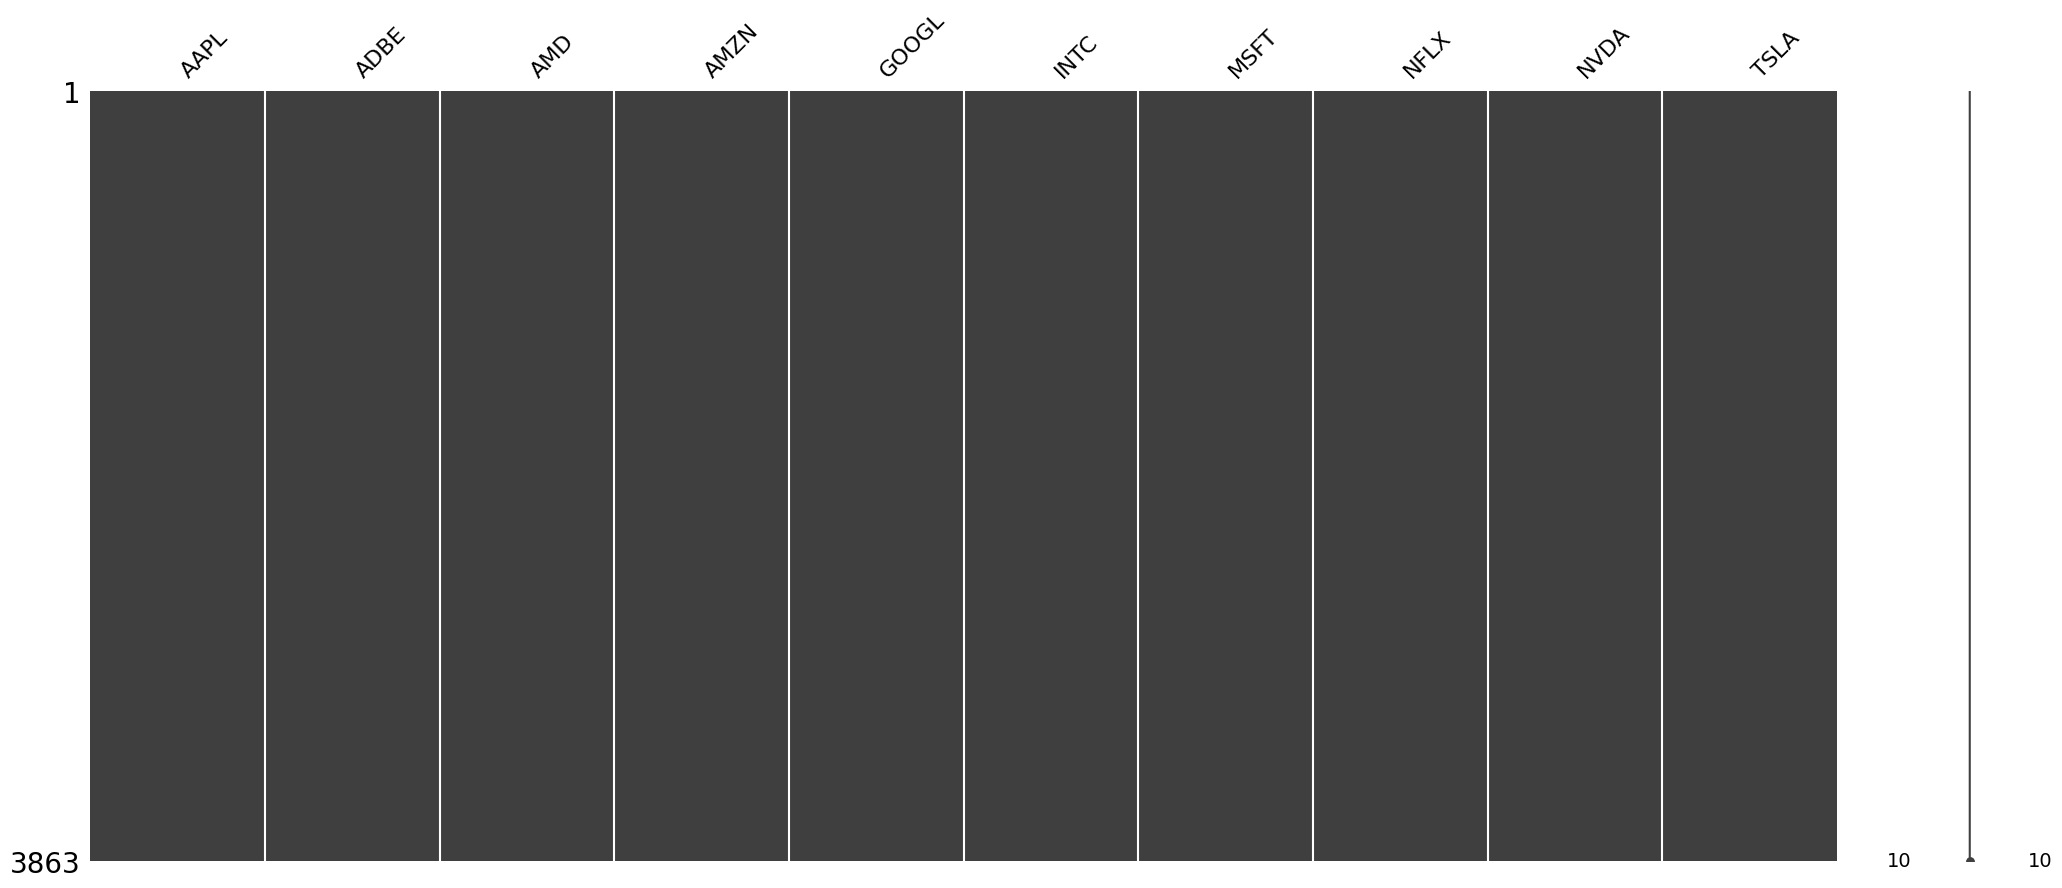

In [53]:

# -- PIVOTAR DATOS ---
#

print("Datos transformados a formato 'ancho' (wide):")


df_wide = df_final.pivot(index='date', columns='symbol', values='close')
df_wide = df_wide.dropna(axis=0)

print(df_wide.head())
print(mso.matrix(df_wide))



normalizamos para que empiecen en el mismo sitio en la gráfica

Generando gráfico de rendimiento normalizado...


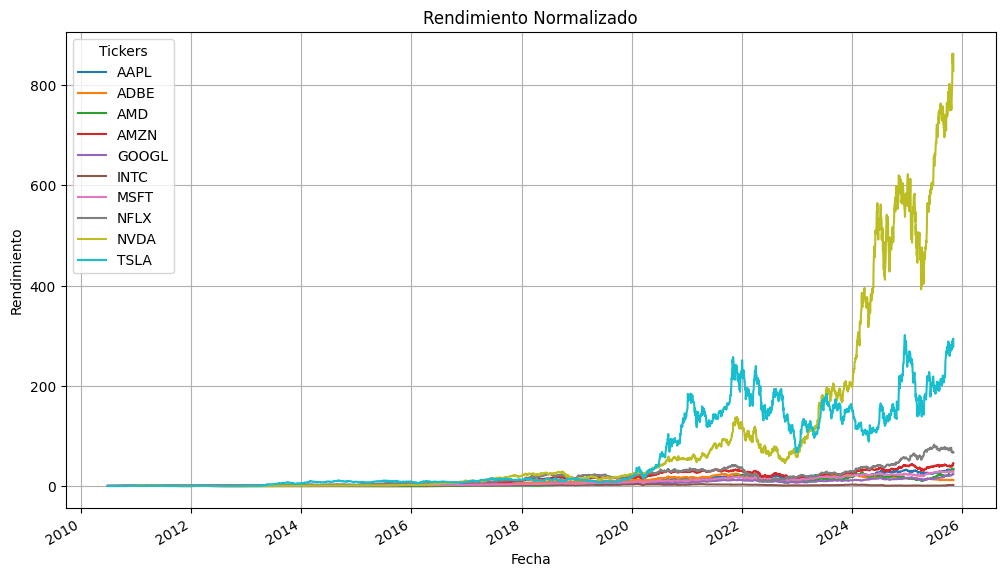

In [54]:

# ---  GRÁFICAR DATOS NORMALIZADOS ---


# 1. Normalizamos: Dividimos el DataFrame "ancho" por su primera fila (iloc[0])

df_normalizado = (df_wide / df_wide.iloc[0]) 

# 2. Graficamos el DataFrame normalizado
print("Generando gráfico de rendimiento normalizado...")

df_normalizado.plot(figsize=(12, 7))
plt.title('Rendimiento Normalizado')
plt.ylabel('Rendimiento')
plt.xlabel('Fecha')
plt.grid(True)
plt.legend(title='Tickers')
plt.show()

Calculamos la media y mediana de los rendimientos logarítmicos

In [55]:
log_returns = np.log(df_wide).diff().dropna()


portfolio_return = log_returns.mean(axis=1)



# -CÁLCULO DE ESTADÍSTICAS ---

# media
mean_returns = log_returns.mean()

# mediana
median_returns = log_returns.median()

print("--- Retornos diarios de la Cartera ---")
print(portfolio_return.head())

print("\n--- Estadísticas de la Cartera ---")
print(f"Media diaria (mu):   {portfolio_return.mean():.6f}")
print(f"Std diaria (sigma): {portfolio_return.std():.6f}")

print("--- Media de Retornos Logarítmicos Diarios ---")
print(mean_returns)

print("\n--- Mediana de Retornos Logarítmicos Diarios ---")
print(median_returns)



--- Retornos diarios de la Cartera ---
date
2010-06-30   -0.018111
2010-07-01   -0.002724
2010-07-02   -0.025295
2010-07-06   -0.016002
2010-07-07    0.034561
dtype: float64

--- Estadísticas de la Cartera ---
Media diaria (mu):   0.000974
Std diaria (sigma): 0.016830
--- Media de Retornos Logarítmicos Diarios ---
symbol
AAPL     0.000921
ADBE     0.000653
AMD      0.000909
AMZN     0.000991
GOOGL    0.000829
INTC     0.000271
MSFT     0.000874
NFLX     0.001092
NVDA     0.001740
TSLA     0.001458
dtype: float64

--- Mediana de Retornos Logarítmicos Diarios ---
symbol
AAPL     0.000942
ADBE     0.001119
AMD      0.000000
AMZN     0.000999
GOOGL    0.001037
INTC     0.000546
MSFT     0.000759
NFLX     0.000383
NVDA     0.000000
TSLA     0.001019
dtype: float64


Calculamos la matriz de correlación

DataFrame de Retornos Logarítmicos Diarios:
symbol          AAPL      ADBE       AMD      AMZN     GOOGL      INTC  \
date                                                                     
2010-06-30 -0.018373 -0.017627 -0.021622  0.005510 -0.020582 -0.017837   
2010-07-01 -0.011992  0.008665  0.009517  0.016349 -0.012739 -0.010224   
2010-07-02 -0.006725  0.002622 -0.030222 -0.016349 -0.006431 -0.002374   
2010-07-06  0.006725 -0.014698 -0.018297  0.007299 -0.000922  0.014162   
2010-07-07  0.040715  0.016940  0.048520  0.030441  0.031778  0.033797   

symbol          MSFT      NFLX     NVDA      TSLA  
date                                               
2010-06-30 -0.012572 -0.035447 -0.04256  0.000000  
2010-07-01  0.006306  0.009619  0.04256 -0.085298  
2010-07-02  0.004561 -0.023895 -0.04256 -0.131576  
2010-07-06  0.023610  0.001306  0.00000 -0.179201  
2010-07-07  0.019803  0.099928  0.04256 -0.018868  


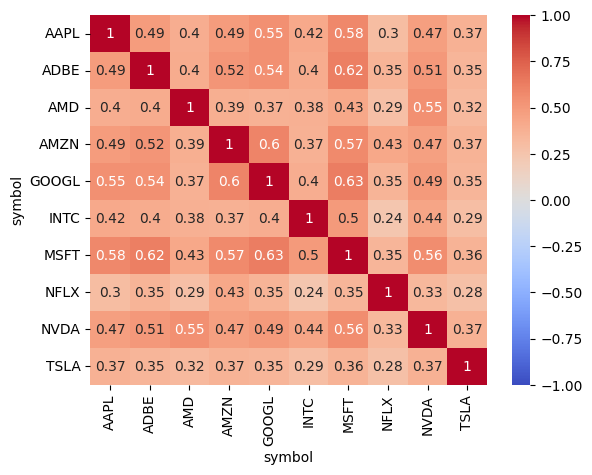

In [56]:

print("DataFrame de Retornos Logarítmicos Diarios:")
print(log_returns.head())

sns.heatmap(log_returns.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()



Una vez que tenemos la cartera vamos a calcular los pesos optimos. En este caso he usado tomado la cartera de mínima volatilidad

-Cartera de míniva volatilidad <br>


OJO SIEMPRE VAMOS A ASUMIR QUE NO PODEMOS TENER POSICIONES CORTAS EN LOS VALORES

In [57]:

#Función de calculo de mínima volatilidad de los ejercicios de Alfonso 2024
def cartera_min_vol (ret):
    
    ''' Función que calcula la cartera de mínima varianza para un DataFrame de rendimientos
    ret: DataFrame de rendimientos
    Retorna pesos_ajustados: Array con los pesos de la cartera de mínima varianza'''
    
    if isinstance(ret, pd.DataFrame): # Verifico que el argumento sea un DataFrame
    
        num_act = ret.shape[1]
        matriz_cov = ret.cov().to_numpy()
        
            #Variables de decisión
        pesos = cp.Variable(num_act)
        
        #Restricciones
        constraints = [pesos >= 0,
                    cp.sum(pesos) == 1,
                    ] # Aquí podemos poner más restricciones del tipo, no quiero que haya ningun valor con más de un x% de peso en la cartera.
        
        riesgo = cp.quad_form(pesos, matriz_cov) # Riesgo de la cartera
        objective = cp.Minimize(riesgo) # Minimizar la varianza

      
        prob = cp.Problem(objective, constraints)
        resultado = prob.solve()

        pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value]) #Pongo a cero los pesos menores a 10^-4 y redondeo a 3 decimales

        return pesos_ajustados
    
    else:
        raise ValueError('La función cartera_min_vol solo acepta un DataFrame como argumento') # Si el argumento no es un DataFrame, lanzo un error

# --- Cálculo de los pesos ---


try:

    #Uso log_returns como mi DataFrame de rendimientos
   
    pesos_calculados = cartera_min_vol(log_returns)
    
    # Para el gráfico, es mejor tener los tickers/nombres de los activos
    activos = log_returns.columns
    
    # Creamos una Serie de pandas para manejar mejor los datos (pesos y activos)
    cartera_min_vol_series = pd.Series(pesos_calculados, index=activos)
    
    print("Cartera de Mínima Volatilidad:")
    print(cartera_min_vol_series)


except Exception as e:
    print(f"Ocurrió un error: {e}")
    print("Asegúrate de que tu variable de rendimientos sea un DataFrame de pandas con los retornos.")

Cartera de Mínima Volatilidad:
symbol
AAPL     0.235
ADBE     0.046
AMD      0.000
AMZN     0.037
GOOGL    0.225
INTC     0.110
MSFT     0.320
NFLX     0.028
NVDA     0.000
TSLA     0.000
dtype: float64


Creamos un gráfico de donut con los pesos de cada activo

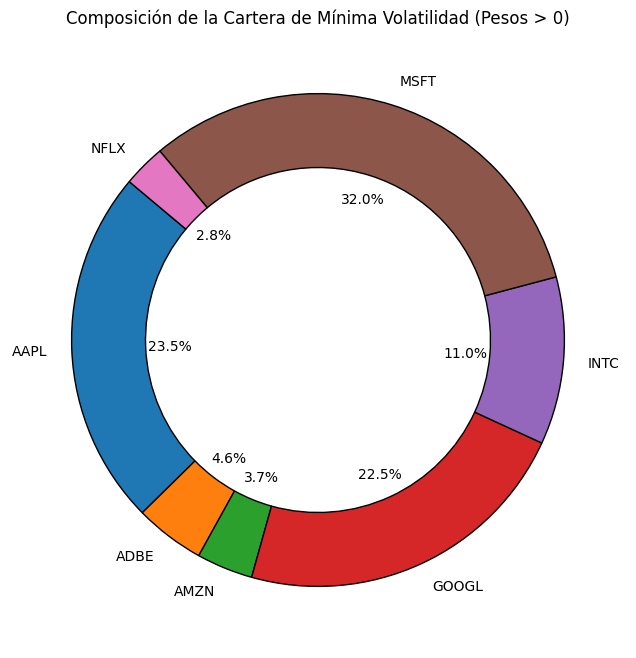

In [58]:

# --- Gráfico de Dónut ---

# Usamos los datos de la 'cartera_min_vol_series' calculada en la celda anterior


try:
    if 'cartera_min_vol_series' in locals() and not cartera_min_vol_series.empty:
        
       
        cartera_a_graficar = cartera_min_vol_series[cartera_min_vol_series > 0] #Para que no sea confuso el gráfico, solo represento llos valores >0
        
   
       
        plt.figure(figsize=(8, 8))

        # Usamos 'cartera_a_graficar.values' para los tamaños y 'cartera_a_graficar.index' para las etiquetas
        plt.pie(cartera_a_graficar.values, labels=cartera_a_graficar.index, 
                autopct='%1.1f%%', startangle=140, 
                wedgeprops={'width': 0.3, 'edgecolor': 'black'})

        # Añadir título
        plt.title('Composición de la Cartera de Mínima Volatilidad (Pesos > 0)')

        # Mostrar el gráfico
        plt.show()
        
    else:
        print("No se pudo generar el gráfico.")
        print("Asegúrate de que la celda anterior se haya ejecutado correctamente y 'cartera_min_vol_series' contenga datos.")

except NameError:
    print("Error: La variable 'cartera_min_vol_series' no está definida. Asegúrate de ejecutar la celda anterior primero.")
except Exception as e:
    print(f"Ocurrió un error al graficar: {e}")

Calculamos los retornos logarítmicos de la cartera optimizada


In [67]:

# CÁLCULO DE LOS RETORNOS HISTÓRICOS DEL PORTAFOLIO OPTIMIZADO

print("Calculando retornos históricos del portfolio optimizado (Min. Vol.)...")

# 1. Obtener los retornos logarítmicos de los activos individuales
#    (Asegúrate de que 'df_wide' de la celda 17 esté disponible)
try:
    log_returns_activos = np.log(df_wide).diff().dropna()
except NameError:
    print("Error: 'df_wide' no está definida. Asegúrate de ejecutar la celda 17.")
    raise

# 2. Calcular los retornos logarítmicos diarios del PORTAFOLIO OPTIMIZADO
#    Usamos .dot() y los pesos de 'cartera_min_vol_series' (de celda 42)
try:
    # .dot() de Pandas alinea automáticamente los activos por sus nombres (índice)
    portfolio_log_returns = log_returns_activos.dot(cartera_min_vol_series)
    portfolio_log_returns.name = 'Portfolio_MinVol_LogReturn'
except NameError:
    print("Error: 'cartera_min_vol_series' no está definida.")
    print("Asegúrate de ejecutar la celda 42 (Cálculo Mínima Volatilidad) antes de esta.")
    raise

# 3. Calcular la media y desviación estándar de los retornos del PORTAFOLIO
#    Estos son los inputs que necesitarán las celdas 28 (MC) y 31 (VaR)
mu_portfolio_diario = portfolio_log_returns.mean()
sigma_portfolio_diario = portfolio_log_returns.std()

print("Cálculo completado.")
print(f"Media (mu) diaria del portfolio (log):   {mu_portfolio_diario:.6f}")
print(f"Std Dev (sigma) diaria del portfolio (log): {sigma_portfolio_diario:.6f}")



Calculando retornos históricos del portfolio optimizado (Min. Vol.)...
Cálculo completado.
Media (mu) diaria del portfolio (log):   0.000810
Std Dev (sigma) diaria del portfolio (log): 0.014232

Últimos 5 retornos diarios del portfolio optimizado:
date
2025-10-29    0.002902
2025-10-30   -0.006905
2025-10-31   -0.002179
2025-11-03   -0.000380
2025-11-04   -0.014030
Name: Portfolio_MinVol_LogReturn, dtype: float64


coparación pesos iguales, a pesos optimizados con mínima volatilidad

Generando gráficos comparativos de retornos...
Mostrando Gráfico 1: Distribución de Densidad (KDE)...


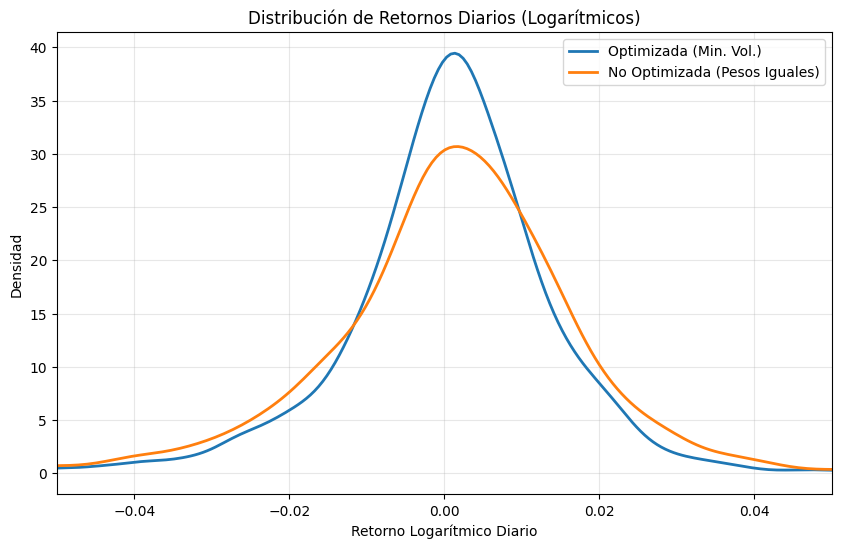

In [ ]:

# GRÁFICA COMPARATIVA: RETORNOS OPTIMIZADOS vs. NO OPTIMIZADOS

print("Generando gráficos comparativos de retornos...")

try:
    # 1. Recuperar los retornos optimizados (calculados en la celda anterior)
    returns_optimizados = portfolio_log_returns
    
    # 2. Calcular los retornos NO optimizados (pesos iguales)
    #    (Usa 'log_returns_activos' de la celda anterior)
    returns_no_optimizados = log_returns_activos.mean(axis=1)
    
    # 3. Ponerlos en un solo DataFrame para comparar fácil
    df_comparativo = pd.DataFrame({
        'Optimizada (Min. Vol.)': returns_optimizados,
        'No Optimizada (Pesos Iguales)': returns_no_optimizados
    }).dropna()

except NameError:
    print("Error: Faltan variables ('portfolio_log_returns' o 'log_returns_activos').")
    print("Asegúrate de ejecutar la celda anterior ('CÁLCULO DE LOS RETORNOS HISTÓRICOS') primero.")
    raise

# Muestra el RIESGO (volatilidad)

plt.figure(figsize=(10, 6))
df_comparativo.plot(kind='kde', ax=plt.gca(), linewidth=2)
plt.title('Distribución de Retornos Diarios (Logarítmicos)')
plt.xlabel('Retorno Logarítmico Diario')
plt.ylabel('Densidad')
plt.grid(alpha=0.3)

# Zoom en la parte central de la distribución
plt.xlim(-0.05, 0.05) 
plt.show()





Ahora vamos con las simulaciones Monte-Carlo


--- Iniciando Simulación Monte Carlo ---
Parámetros usados para la simulación del portfolio:
  - Valor inicial (S0): 100
  - Días a simular (n_days): 30
  - Número de simulaciones (n_sims): 1000
  - Media diaria retorno log (mu_daily): 0.000810
  - Desv. Est. diaria retorno log (sigma_daily): 0.014232
  - Paso de tiempo (dt): 0.003968

Generando gráfico de las simulaciones...


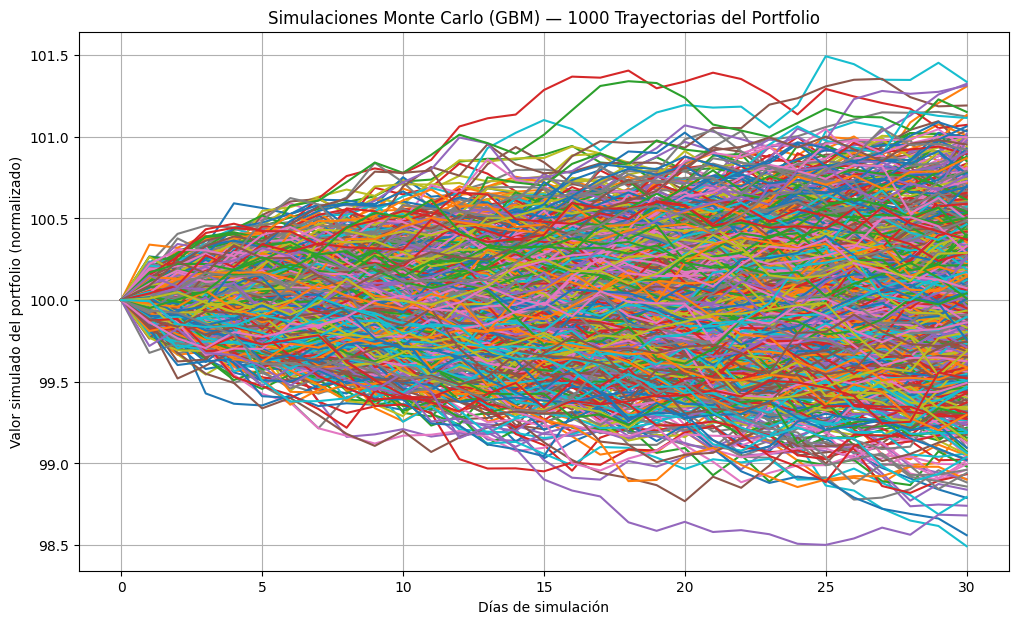

In [73]:

# --- SIMULACIÓN MONTE CARLO ---
print("\n--- Iniciando Simulación Monte Carlo ---")

# Parámetros de la simulación
n_sims = 1000     # Número de simulaciones
n_days = 30       # Días a simular hacia adelante
S0 = 100          # Valor inicial del portfolio (normalizado a 100 para comparar)
dt = 1 / 252      # Paso de tiempo (asumiendo 252 días de trading al año)

try:
  
    print(f"Parámetros usados para la simulación del portfolio:")
    print(f"  - Valor inicial (S0): {S0}")
    print(f"  - Días a simular (n_days): {n_days}")
    print(f"  - Número de simulaciones (n_sims): {n_sims}")
    print(f"  - Media diaria retorno log (mu_daily): {mu_portfolio_diario:.6f}")
    print(f"  - Desv. Est. diaria retorno log (sigma_daily): {sigma_portfolio_diario:.6f}")
    print(f"  - Paso de tiempo (dt): {dt:.6f}")

    # Inicializar generador de números aleatorios
    rng = default_rng()

    # 4. Generar las trayectorias (Usando Movimiento Browniano Geométrico - GBM)
    paths = np.zeros((n_days + 1, n_sims))
    paths[0, :] = S0 # Establecer el valor inicial para todas las simulaciones

    for t in range(1, n_days + 1):
        # Generar números aleatorios normales estándar para este paso de tiempo
        Z = rng.standard_normal(n_sims)
        # Calcular el precio para este día en todas las simulaciones
        paths[t, :] = paths[t - 1, :] * np.exp(
            (mu_portfolio_diario - 0.5 * sigma_portfolio_diario**2) * dt +  # Componente de deriva
            sigma_portfolio_diario * np.sqrt(dt) * Z             # Componente aleatorio (shock)
        )

    # 5. Graficar las trayectorias simuladas usando Matplotlib
    print("\nGenerando gráfico de las simulaciones...")
    plt.figure(figsize=(12, 7)) # Crear una figura nueva para el gráfico
    plt.plot(paths)
    plt.title(f'Simulaciones Monte Carlo (GBM) — {n_sims} Trayectorias del Portfolio')
    plt.xlabel('Días de simulación')
    plt.ylabel('Valor simulado del portfolio (normalizado)')
    plt.grid(True)
    # No añadimos leyenda para no saturar el gráfico con 100 entradas
    #plt.savefig('monte_carlo_simulation.png') # Guardar el gráfico como imagen (por ahora no lo estoy guardando)
    #print("Gráfico 'monte_carlo_simulation.png' guardado.")

except NameError as e:
     print(f"Error: La variable 'df_wide' no está definida. Asegúrate de ejecutar la celda 17 antes. ({e})")
except Exception as e:
    print(f"Ocurrió un error inesperado durante la simulación: {e}")

Con estas simulaciones calculamos el Value at risk.(Utiliza los datos de las simulaciones monte Carlo de la celda anterior)


--- Calculando Value at Risk (VaR) ---
Resultados basados en 10000 simulaciones de 30 días:
Nivel de Confianza: 95%
Nivel de Significancia (alpha): 5%
Percentil 5 de retorno simulado a 30 días: -0.0094
Value at Risk (VaR) al 95% de confianza para 30 días: 0.0094 (o 0.94%)
Interpretación: Basado en 10000 simulaciones, hay una probabilidad del 5% de que la pérdida del portfolio exceda el 0.94% en los próximos 30 días.

Generando histograma de retornos simulados a 30 días y VaR...


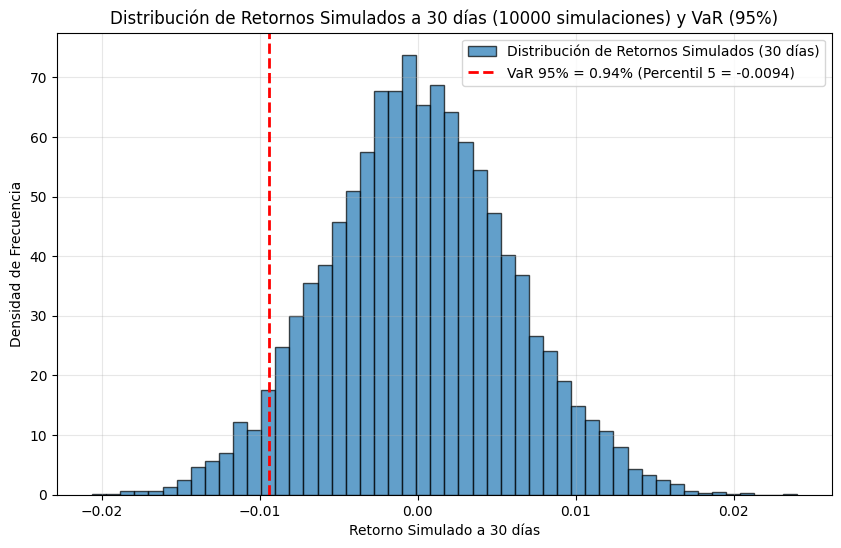

In [61]:

# --- Value at Risk (VaR) Calculation using previous Simulation Paths ---
print("\n--- Calculando Value at Risk (VaR) ---")

try:
    # 1. Verificar si las variables necesarias de la simulación anterior existen
    if 'paths' not in locals() or 'S0' not in locals() or 'n_days' not in locals() or 'n_sims' not in locals():
        raise NameError("Variables de simulación (paths, S0, n_days, n_sims) no encontradas. Ejecuta la celda Monte Carlo de trayectorias primero.")

    # 2. Obtener los valores simulados finales (del último día simulado)
    final_values = paths[n_days, :] # Última fila (día n_days) para todas las simulaciones (n_sims)

    # 3. Calcular los retornos simulados (retornos simples) sobre el período simulado (n_days)
    #    (Valor Final - Valor Inicial) / Valor Inicial
    simulated_returns = (final_values - S0) / S0

    # 4. Definir nivel de confianza y calcular VaR
    confidence_level = 0.95
    alpha = 1 - confidence_level # Nivel de significancia (0.05)

    # VaR es el percentil alpha de las *pérdidas* (retornos negativos),
    # o el negativo del percentil alpha de los *retornos*.
    var_percentile = np.percentile(simulated_returns, alpha * 100) # 5º percentil para confianza del 95%

    # El VaR se expresa como una pérdida potencial positiva
    var_value = -var_percentile

    print(f"Resultados basados en {n_sims} simulaciones de {n_days} días:")
    print(f"Nivel de Confianza: {confidence_level:.0%}")
    print(f"Nivel de Significancia (alpha): {alpha:.0%}")
    print(f"Percentil {alpha*100:.0f} de retorno simulado a {n_days} días: {var_percentile:.4f}")
    print(f"Value at Risk (VaR) al {confidence_level:.0%} de confianza para {n_days} días: {var_value:.4f} (o {var_value:.2%})")
    print(f"Interpretación: Basado en {n_sims} simulaciones, hay una probabilidad del {alpha:.0%} de que la pérdida del portfolio exceda el {var_value:.2%} en los próximos {n_days} días.")

    # 5. Graficar histograma de retornos y marcar el VaR
    print(f"\nGenerando histograma de retornos simulados a {n_days} días y VaR...")
    plt.figure(figsize=(10, 6)) # Crear figura nueva
    plt.hist(simulated_returns, bins=50, alpha=0.7, density=True, edgecolor='black', label=f'Distribución de Retornos Simulados ({n_days} días)')
    # Añadir línea vertical para el VaR (en el valor de pérdida, que es -VaR95)
    plt.axvline(var_percentile, color='r', linestyle='dashed', linewidth=2,
                label=f'VaR {confidence_level:.0%} = {var_value:.2%} (Percentil {alpha*100:.0f} = {var_percentile:.4f})')
    plt.title(f'Distribución de Retornos Simulados a {n_days} días ({n_sims} simulaciones) y VaR ({confidence_level:.0%})')
    plt.xlabel(f'Retorno Simulado a {n_days} días')
    plt.ylabel('Densidad de Frecuencia')
    plt.legend()
    plt.grid(alpha=0.3)
    # plt.savefig('monte_carlo_paths_var_histogram.png') # Guardar gráfico por ahora no quiero guardarlo
    
    # print("Gráfico 'monte_carlo_paths_var_histogram.png' guardado.")


except NameError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado durante el cálculo del VaR: {e}")